## This is my attempt to use siamese with gan idea

In [1]:
use_kaggle = 0

if use_kaggle:
    #!pip install git+https://github.com/fastai/fastai.git
    !git clone https://github.com/benwu232/humpback
    import sys
     # Add directory holding utility functions to path to allow importing utility funcitons
    #sys.path.insert(0, '/kaggle/working/protein-atlas-fastai')
    sys.path.append('/kaggle/humback/')

In [2]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

if use_kaggle:
    from humpback.utils import *
else:
    from utils import *
    
from IPython.core.debugger import set_trace
#from functional import seq

In [3]:
fastai.__version__

'1.0.44.dev0'

In [4]:
root_path = Path('../input')
train_path = root_path/'train'
test_path = root_path/'test'
learn_path = Path('../')

USE_CUDA = torch.cuda.is_available()

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if USE_CUDA else "cpu")

In [5]:
#name = f'siamese_resnet34_224'
#arch = models.resnet34
name = f'siamese_resnet18_224'
arch = models.resnet18

im_size = 224
train_batch_size = 64
val_batch_size = 128
if use_kaggle:
    dl_workers = 0
else:
    dl_workers = 6
SEED=0
emb_len = 256

In [6]:
df0 = pd.read_csv('../input/train.csv')
df_new = df0[df0.Id == 'new_whale']
df_known = df0[df0.Id != 'new_whale']
train_list, val_list = split_whale_set(df0, nth_fold=0, new_whale_method=1, seed=1)

im_count = df0[df0.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
ex_df = df0.join(im_count, on='Id')

path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
fn2label = {row[1].Image: row[1].Id for row in df0.iterrows()}
class_dict = make_whale_class_dict(df0)
file_lut = df0.set_index('Image').to_dict()

In [7]:
len(val_list)

5471

In [8]:
im_tfms = get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2)

data = (
    ImageItemList
        # .from_df(df_known, 'data/train', cols=['Image'])
        .from_folder(train_path)
        # .split_by_idxs(train_item_list, val_item_list)
        .split_by_valid_func(lambda path: path2fn(str(path)) in val_list)
        # .split_by_idx(val_list)
        # .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path2fn(str(path))])
        #.add_test(ImageItemList.from_folder(test_path))
        #.transform([None, None], size=im_size, resize_method=ResizeMethod.SQUISH)
        .transform(im_tfms, size=im_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=train_batch_size, num_workers=dl_workers, path=root_path)
        #.normalize(imagenet_stats)
)

data.add_tfm(normalize_batch)

train_dl = DataLoader(
    SiameseDs(data.train_ds, data.train_dl),
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_siamese,
    num_workers=dl_workers
)

val_dl = DataLoader(
    SiameseDs(data.valid_ds, data.valid_dl),
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=collate_siamese,
    num_workers=dl_workers
)

In [9]:
train_bunch = ImageDataBunch(train_dl, val_dl, device=device)

In [10]:
#siamese = SiameseNetwork(arch=arch)
#siamese = SiameseNet(emb_len=emb_len, arch=arch, forward_type='similarity', drop_rate=0.5)
siamese = SiameseNet(emb_len=emb_len, arch=arch, forward_type='distance', drop_rate=0.5)
#siamese = SiameseNetwork2(arch=arch)
siamese.to(device)

SiameseNet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [11]:
learn = Learner(train_bunch,
                  siamese,
                  #enable_validate=True,
                  path=learn_path,
                  #loss_func=BCEWithLogitsFlat(),
                  loss_func=ContrastiveLoss(margin=contrastive_neg_margin),
                  metrics=[avg_pos, avg_neg]
                  #metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)]
                  )

In [12]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.fc])

In [13]:
from fastai.callbacks import SaveModelCallback
cb_save_model = SaveModelCallback(learn, every="epoch", name=name)
#cb_siamese_validate = SiameseValidateCallback(learn, txlog)
cbs = [cb_save_model]#, cb_siamese_validate]

In [14]:
learn.freeze_to(-1)
learn.fit_one_cycle(3)
learn.unfreeze()

epoch,train_loss,valid_loss,avg_pos,avg_neg
1,38.817780,14.141239,14.169743,-7.393423
2,16.999418,4.625903,3.569357,5.697971
3,12.595634,4.682240,2.612115,6.782680


LR plotting ...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05


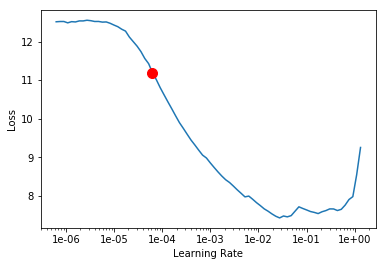

In [15]:
enable_lr_find = 1
if enable_lr_find:
    print('LR plotting ...')
    learn.lr_find()
    learn.recorder.plot()
    plt.savefig('lr_find.png')

In [16]:
max_lr = 1e-4
lrs = [max_lr/20, max_lr/5, max_lr]
learn.fit_one_cycle(100, lrs, callbacks=cbs)

epoch,train_loss,valid_loss,avg_pos,avg_neg
1,12.515120,4.700226,2.528710,6.903825
2,12.519738,4.672958,2.643437,6.732162
3,12.507962,4.685122,2.597113,6.803691
4,12.497748,4.671924,2.683470,6.689217
5,12.519938,4.678540,2.654346,6.732213
6,12.531446,4.678624,2.646241,6.740745
7,12.506563,4.681217,2.605120,6.787756
8,12.511176,nan,2.682613,nan
9,12.531618,4.692305,2.583071,6.832685
10,12.536766,4.692974,2.580631,6.836294
